In [26]:
import torch 
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

In [27]:
%matplotlib inline

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

In [69]:
# paths 
feature = "Eyeglasses"

celebA_csv = "../data/celeba/list_attr_celeba.csv"
female_csv = "../data/celeba/experiment1_Female_{}.csv".format(feature)

male_csv = list()
models_folder = list()

for n in [10, 30, 60, 90]:
    male_csv.append("../data/celeba/experiment1_Male_{}_{}%.csv".format(feature, n))


    models_folder.append( ('../results/Experiment1/{}/{}/Results_CelebA_resnet18/'
                 'input_dim_512/init_trunc_inv_sqrt/layers_4/neuron_512/'
                 'lambda_cvx_0.1_mean_0.0/optim_Adamlr_0.001betas_0.5_0.99/'
                 'gen_5/batch_30/trial_1_last_inp_qudr').format(feature.split("_")[-1], n))

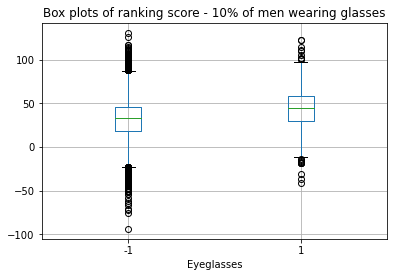

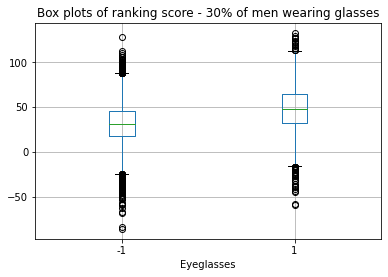

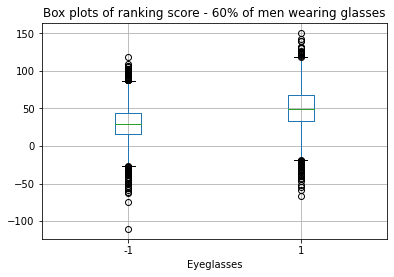

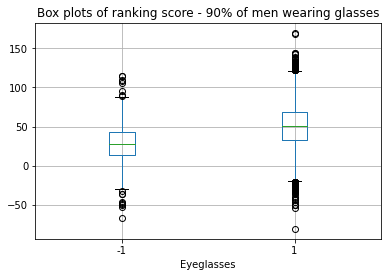

In [70]:
wasserstein = list()
for i in range(4):
    n = [10, 30, 60, 90][i]
    df = pd.read_csv(male_csv[i])
    mean = df["values_resnet18"].mean()
    wasserstein.append(mean)
    
    #print(df[["Wearing_Hat", "values_resnet18"]].corr())
    ax = df.boxplot(column = "values_resnet18", by = feature)
    plt.suptitle("")
    ax.set_title("Box plots of ranking score - {}% of men wearing glasses".format(n))
    
    plt.savefig("../results/Experiment1/{0}/{0}_Boxplot_{1}.png".format(feature.split("_")[-1], n))
    plt.show()

In [71]:
wasserstein

[33.955664090607094, 36.92824829459846, 42.06117135165616, 48.36751568484798]

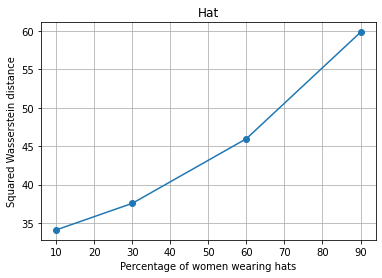

In [52]:
plt.plot([10,30,60,90], wasserstein, "-o")

plt.title("Hat")
plt.xlabel("Percentage of women wearing hats")
plt.ylabel("Squared Wasserstein distance")
plt.grid()

#plt.savefig("../results/Experiment1/Female_Hat/Female_Hat_Wasserstein_distance_plot.png")
plt.show()

<AxesSubplot:title={'center':'values_resnet18'}, xlabel='Wearing_Hat'>

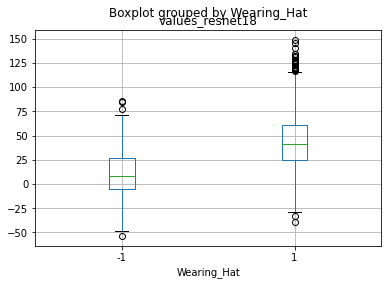

In [36]:
df.boxplot(column = "values_resnet18", by = "Wearing_Hat")

In [9]:
female = pd.read_csv(female_csv)

female.head()

,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,values_resnet18
0,197182,197183.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1,15039.403320
1,169336,169337.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,18833.251953
2,88347,088348.jpg,-1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,1,-1,-1,1,19075.695312
3,47374,047375.jpg,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,1,1,-1,1,-1,-1,1,7137.672852
4,58856,058857.jpg,-1,-1,-1,-1,-1,1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,-1,15862.074219


In [10]:
100*(female["Wearing_Hat"] == 1).sum()/len(female)

2.197642264590307

In [5]:
# import celebA data
df = pd.read_csv(celebA_csv)
df_female = pd.read_csv(female_csv)
df_male = pd.read_csv(male_csv)

df_female.head()

,index,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,values,values1,values_resnet18,values_facenet
0,0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,6629.578613,-828.345459,98403.103900,5.487793
1,1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,6035.264160,-639.834961,104507.229389,5.158328
2,3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,1,-1,1,11405.099609,-720.791931,83298.700580,5.366566
3,4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,1,11328.725586,-594.776306,73223.356830,5.340551
4,5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,...,1,-1,1,-1,-1,1,3073.829590,-995.757385,107948.951923,5.448020


We compute the percentage of men and women for each attribute in CelebA.

In [6]:
# for every attribute, compute the percentage of men and women with that attribute
n_male = len(df[df["Male"] == 1])
n_female = len(df[df["Male"] == -1])

bias = dict()

for col in df.columns:
    n_male_col = len(df[(df["Male"] == 1) & (df[col] == 1)])
    n_female_col = len(df[(df["Male"] == -1) & (df[col] == 1)])
    
    bias[col] = {"Female" : n_female_col/n_female,
                 "Male" : n_male_col/n_male}

bias.pop("image_id")
bias.pop("Male")

{'Female': 0.0, 'Male': 1.0}

In [7]:
# function that saves barplots
def make_barplot(path, column, values):
    plt.bar(["Male", "Female"], [val for key, val in values.items()], color = ["mediumseagreen", "mediumpurple"])
    plt.title(column)
    plt.savefig(path + "/{}.jpeg".format(column))
    plt.show()

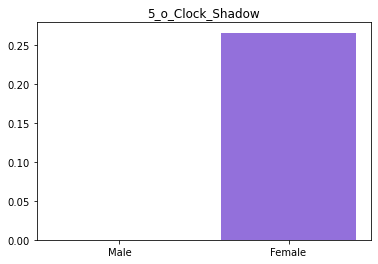

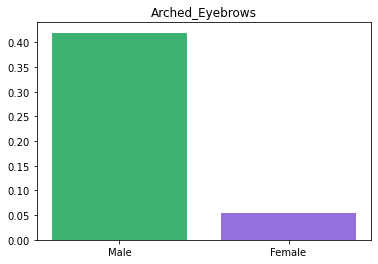

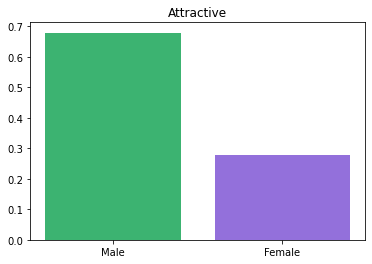

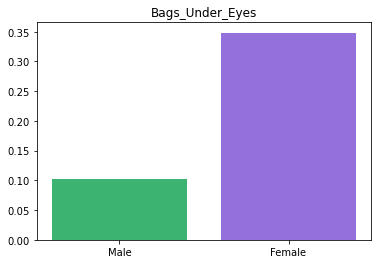

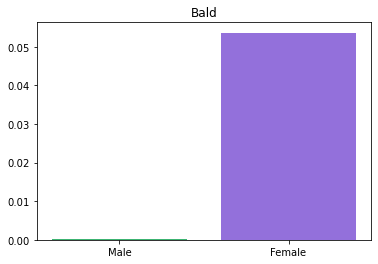

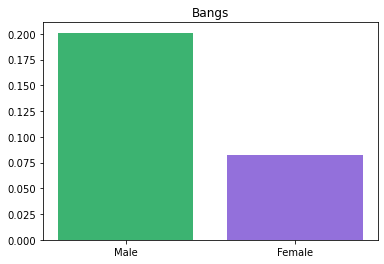

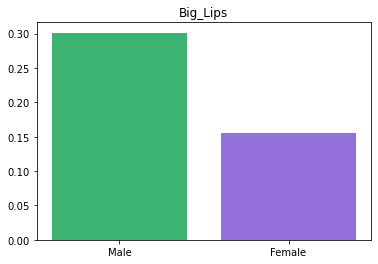

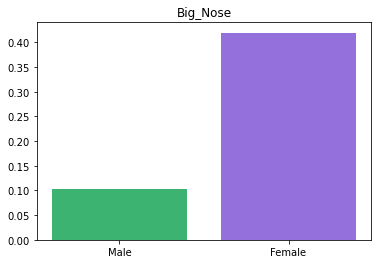

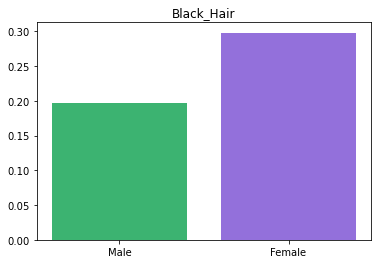

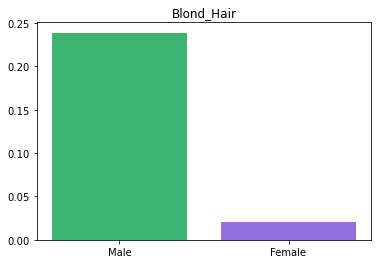

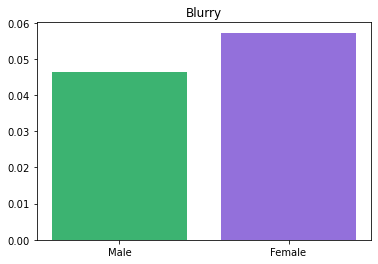

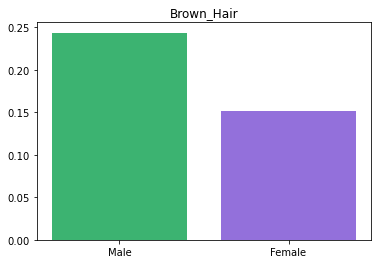

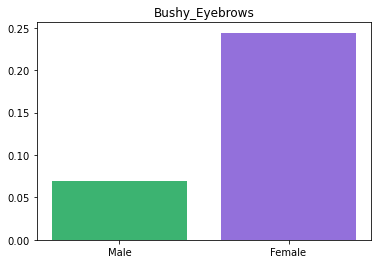

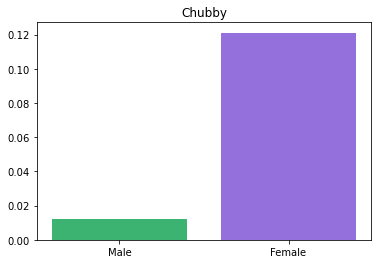

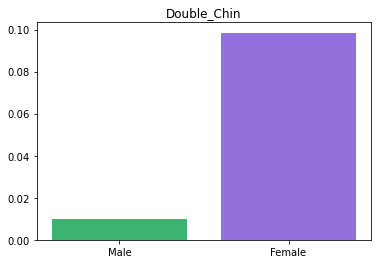

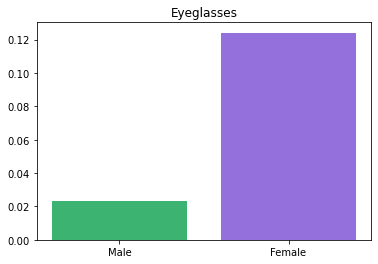

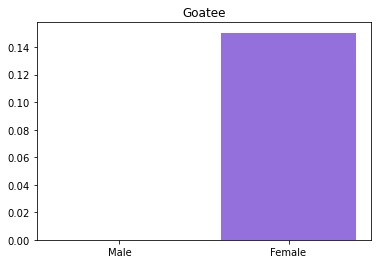

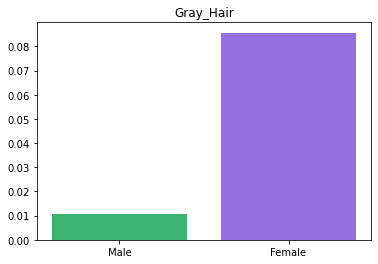

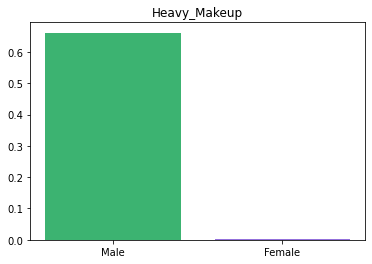

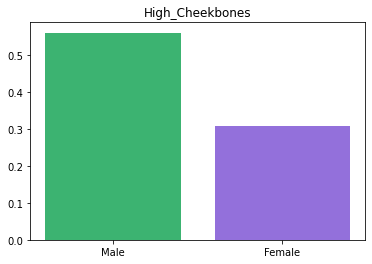

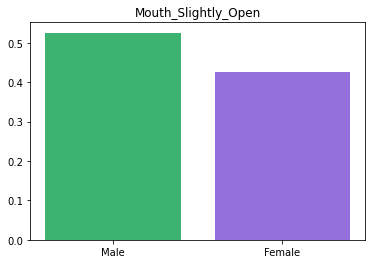

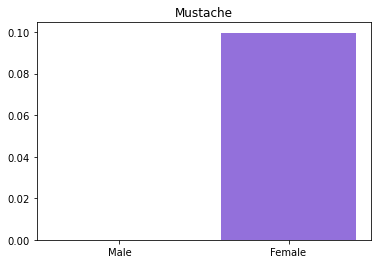

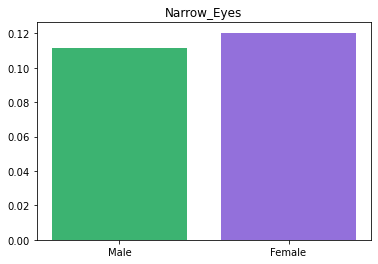

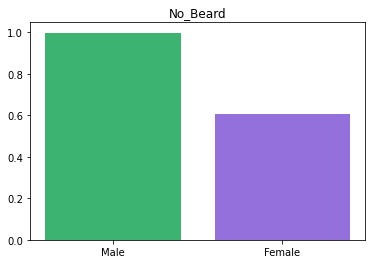

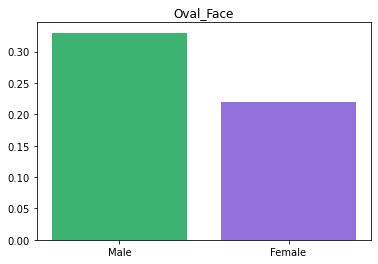

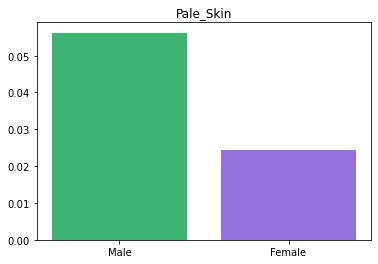

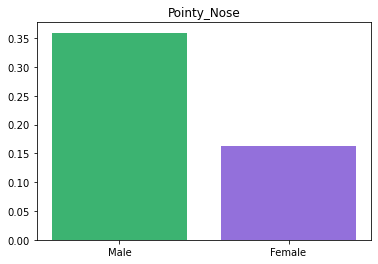

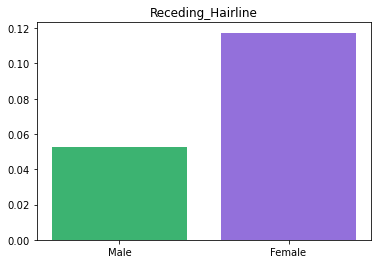

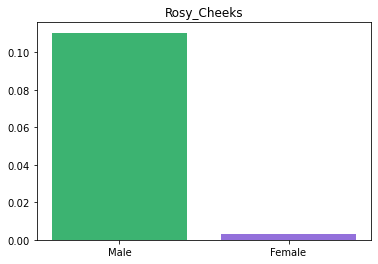

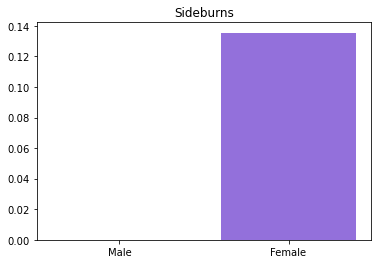

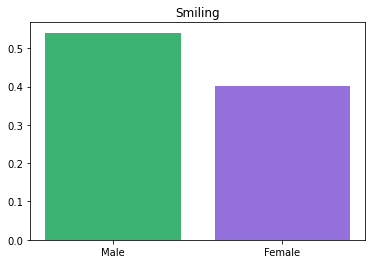

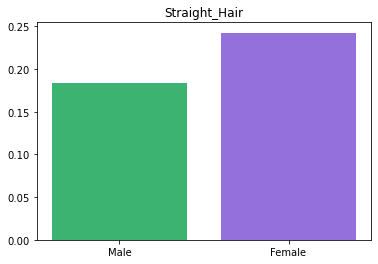

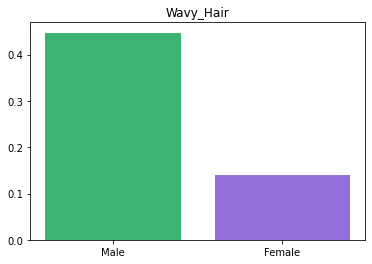

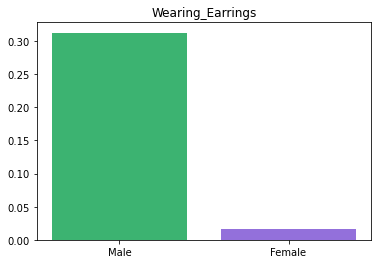

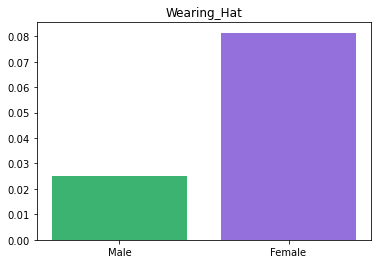

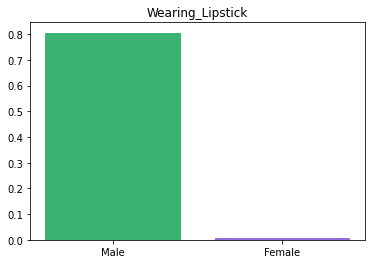

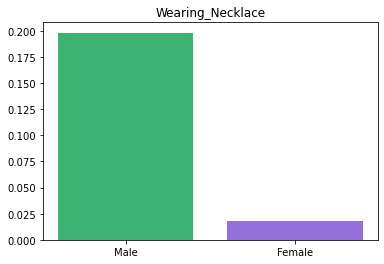

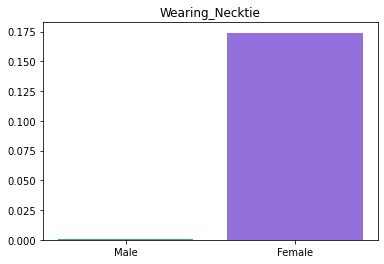

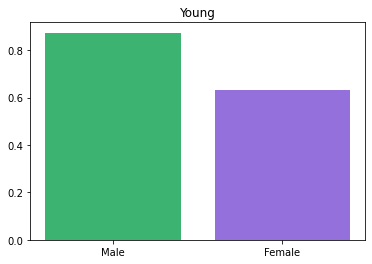

<Figure size 432x288 with 0 Axes>

In [8]:
# save the barplots
for col, values in bias.items():
    make_barplot(results_folder + "/barplots_celeba", col, values)
    plt.clf()

In [9]:
bias.items()

dict_items([('5_o_Clock_Shadow', {'Female': 0.0001692548554986671, 'Male': 0.26643295354951796}), ('Arched_Eyebrows', {'Female': 0.419557398552871, 'Male': 0.05345003197763934}), ('Attractive', {'Female': 0.6791689586595016, 'Male': 0.27925953999573633}), ('Bags_Under_Eyes', {'Female': 0.10190834849574747, 'Male': 0.3482483359783973}), ('Bald', {'Female': 0.00014386662717386705, 'Male': 0.053651372669777576}), ('Bangs', {'Female': 0.20106630558964161, 'Male': 0.08231281237416206}), ('Big_Lips', {'Female': 0.30132441924427705, 'Male': 0.15608641068763768}), ('Big_Nose', {'Female': 0.1022722464350696, 'Male': 0.4196295331264656}), ('Black_Hair', {'Female': 0.19731731054034612, 'Male': 0.2979368500840893}), ('Blond_Hair', {'Female': 0.23893707950746837, 'Male': 0.020714404149986973}), ('Blurry', {'Female': 0.046367367663859856, 'Male': 0.05723997441788853}), ('Brown_Hair', {'Female': 0.24359158803368172, 'Male': 0.1514555747684582}), ('Bushy_Eyebrows', {'Female': 0.06923369864172979, 'Mal

We compute the distribution of the ranking score for men and women with respect to each attribute.

In [10]:
df_female.head()

,index,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,values,values1,values_resnet18,values_facenet
0,0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,6629.578613,-828.345459,98403.103900,5.487793
1,1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,6035.264160,-639.834961,104507.229389,5.158328
2,3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,1,-1,1,11405.099609,-720.791931,83298.700580,5.366566
3,4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,1,11328.725586,-594.776306,73223.356830,5.340551
4,5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,...,1,-1,1,-1,-1,1,3073.829590,-995.757385,107948.951923,5.448020


In [11]:
len(bias)

39

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


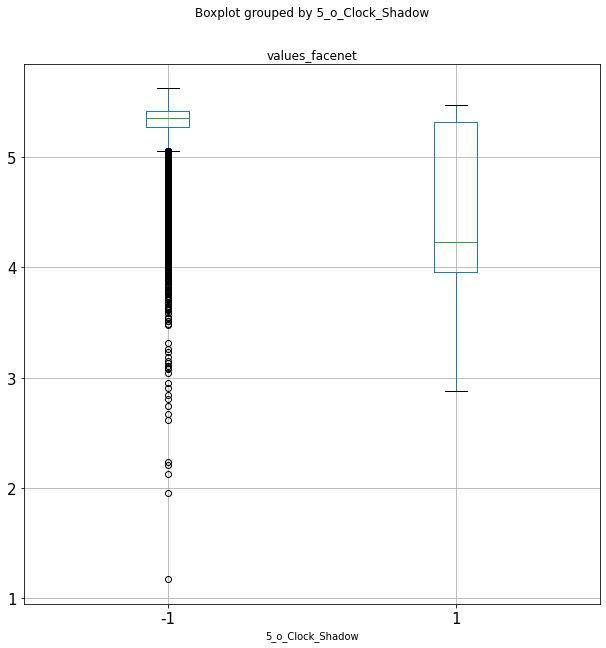

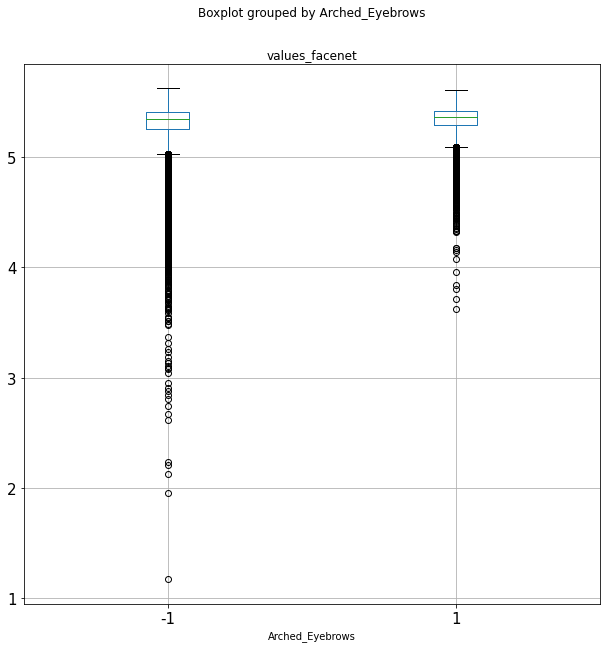

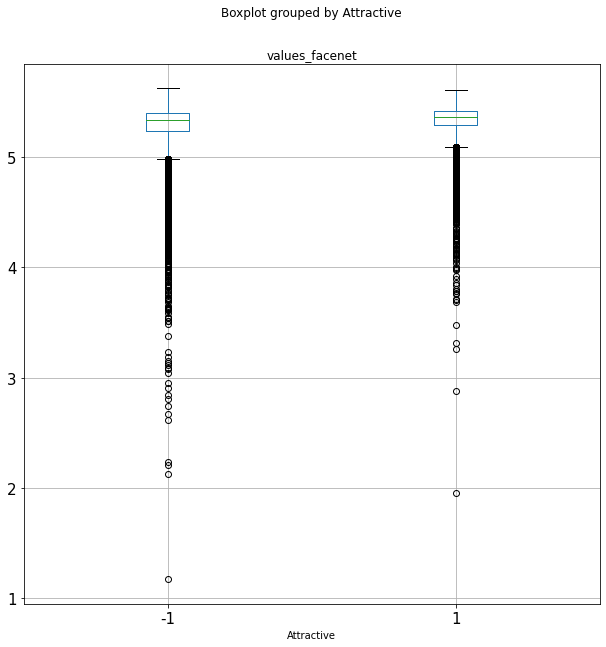

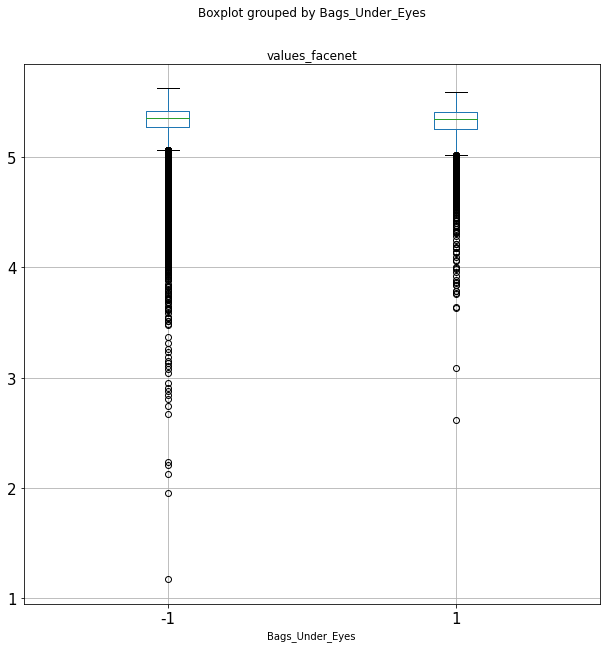

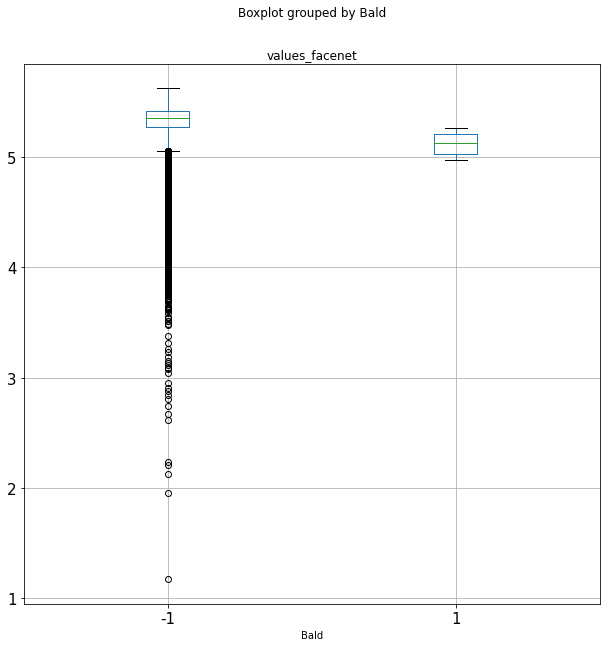

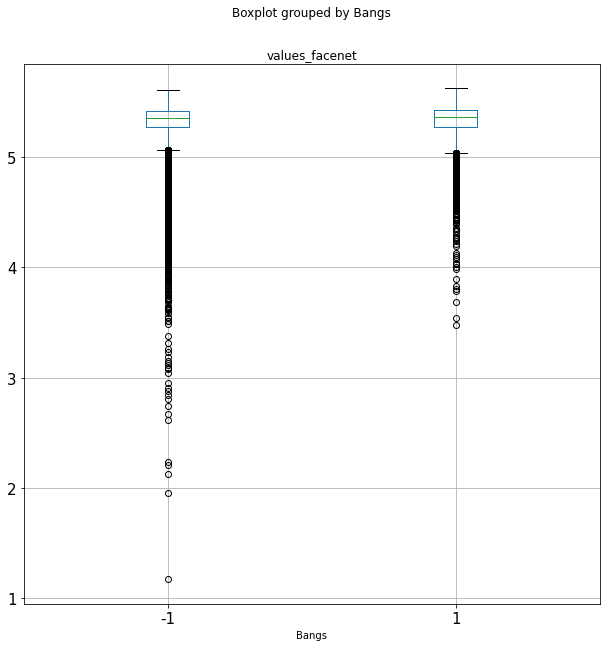

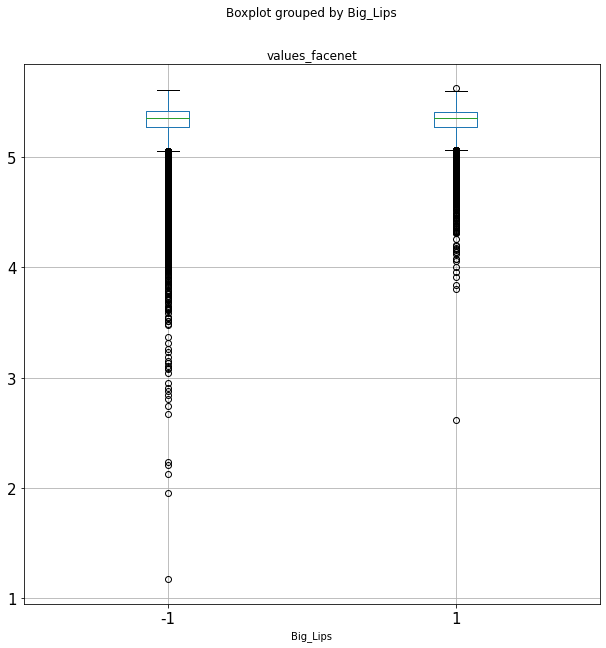

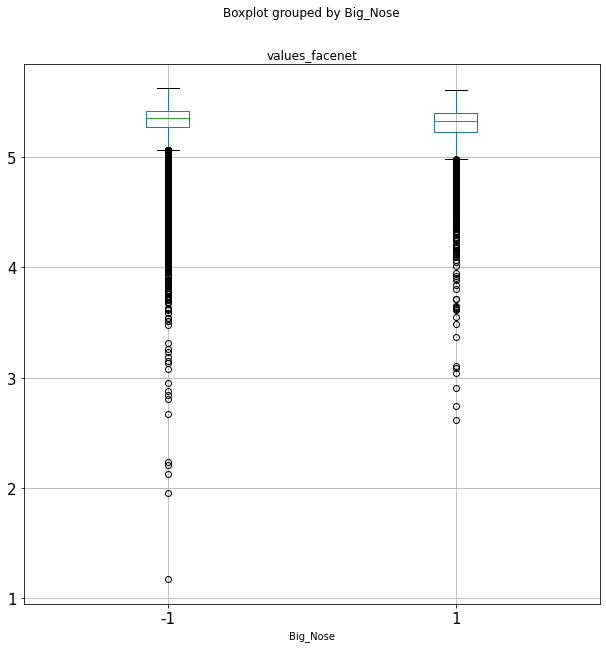

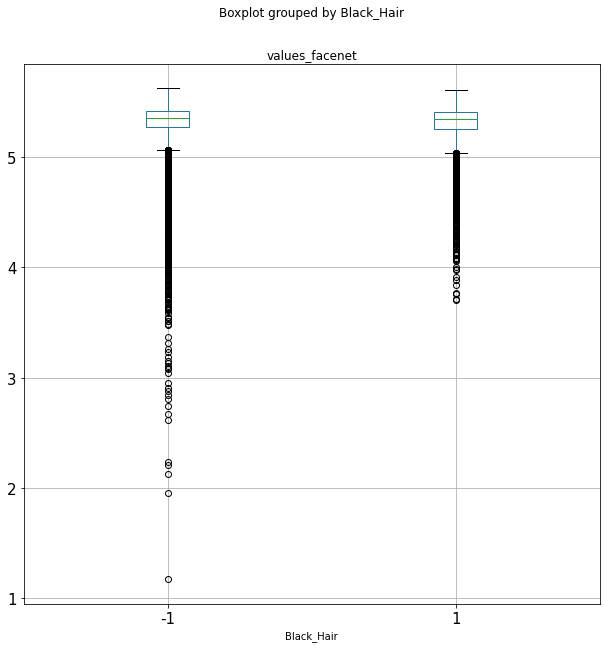

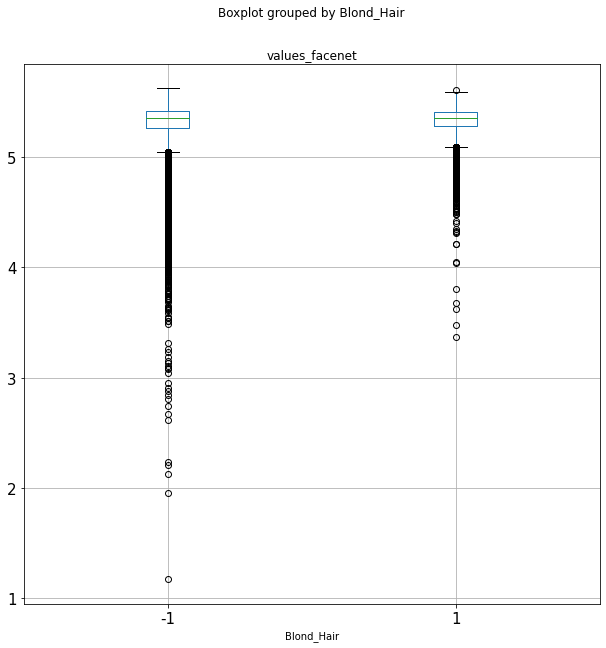

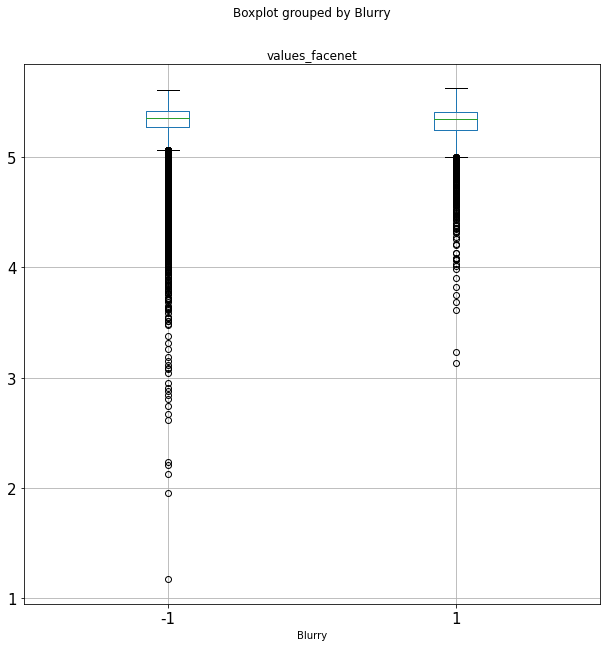

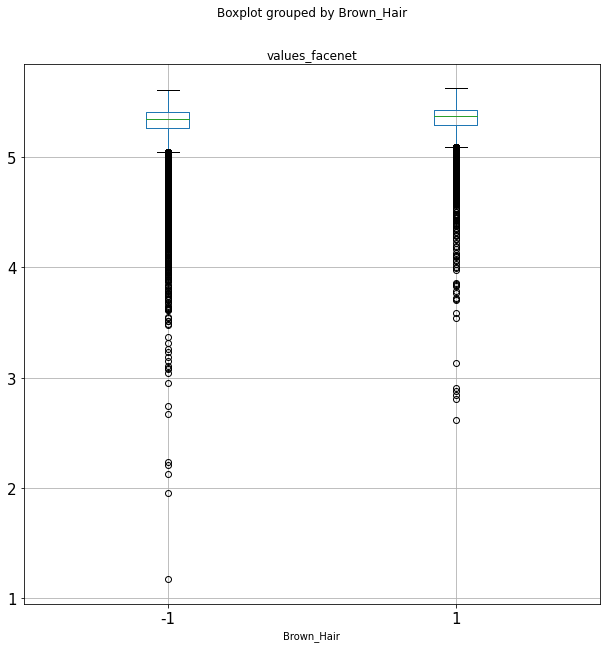

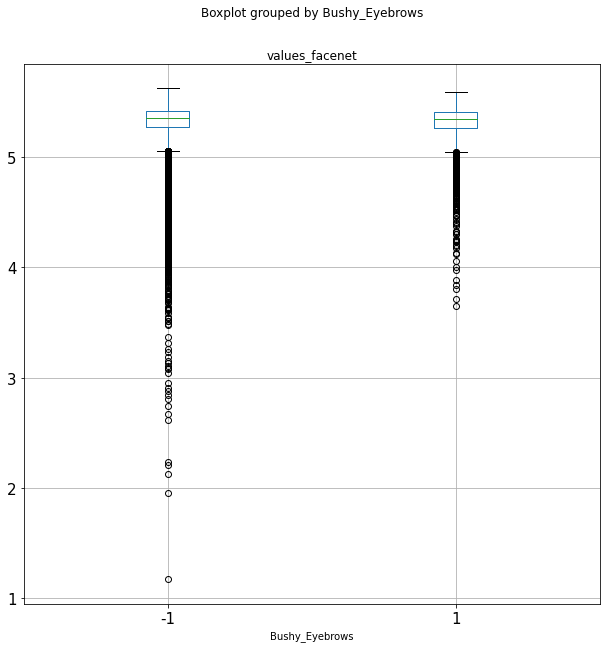

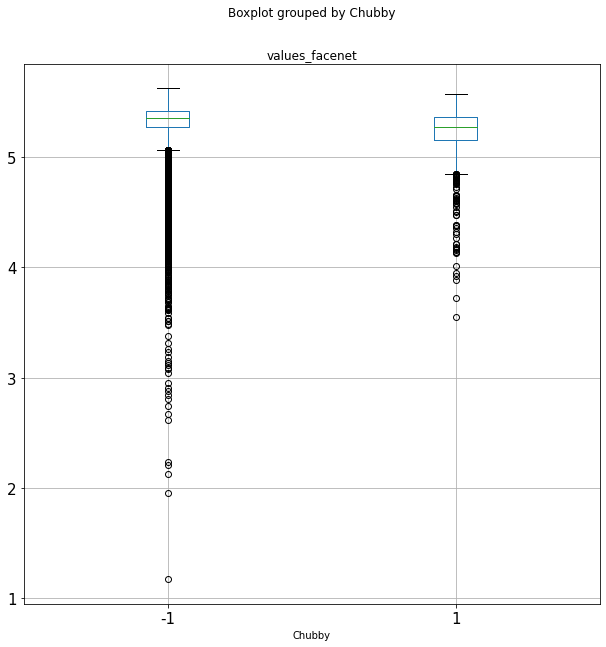

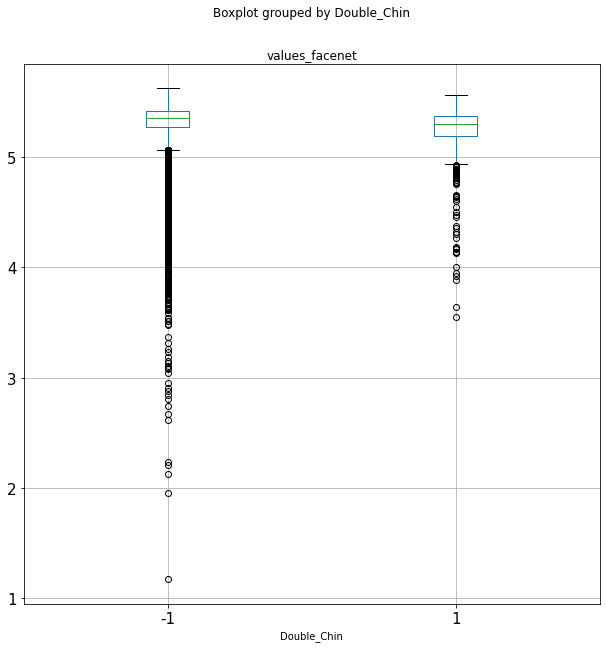

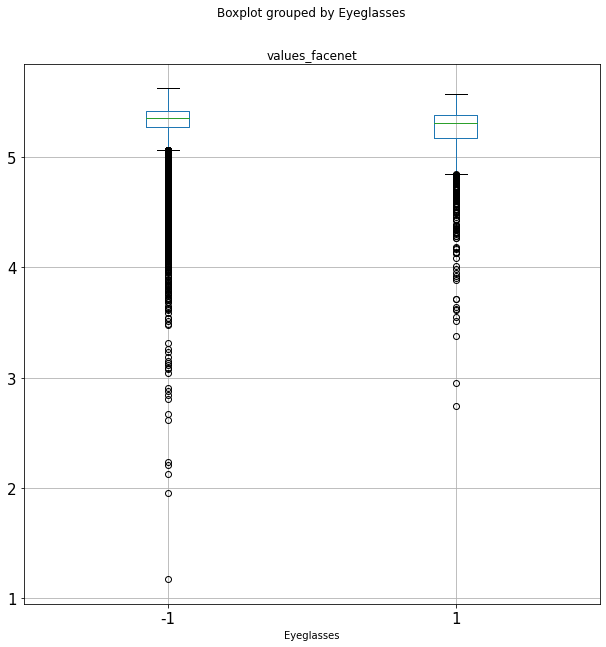

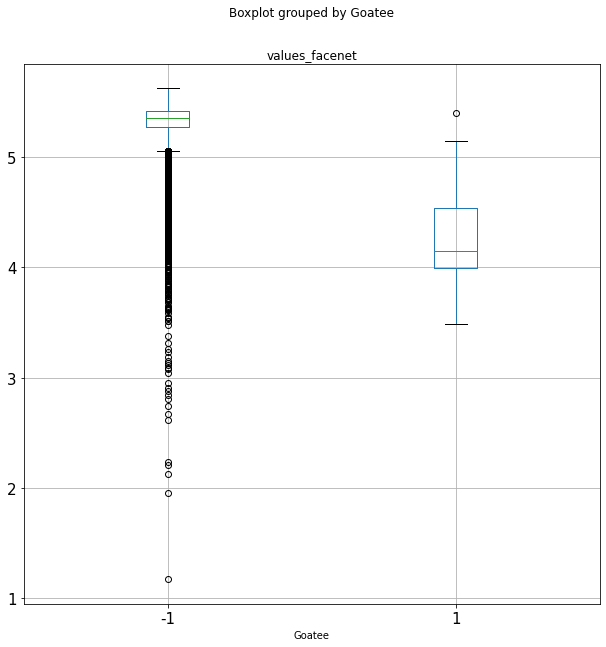

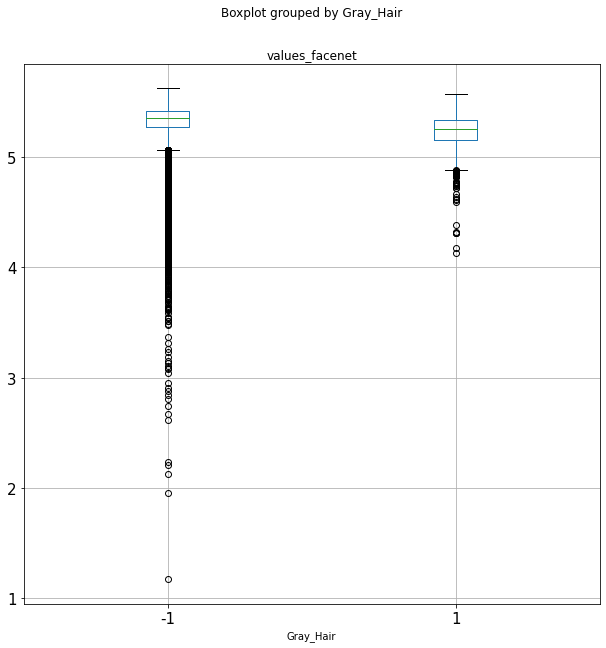

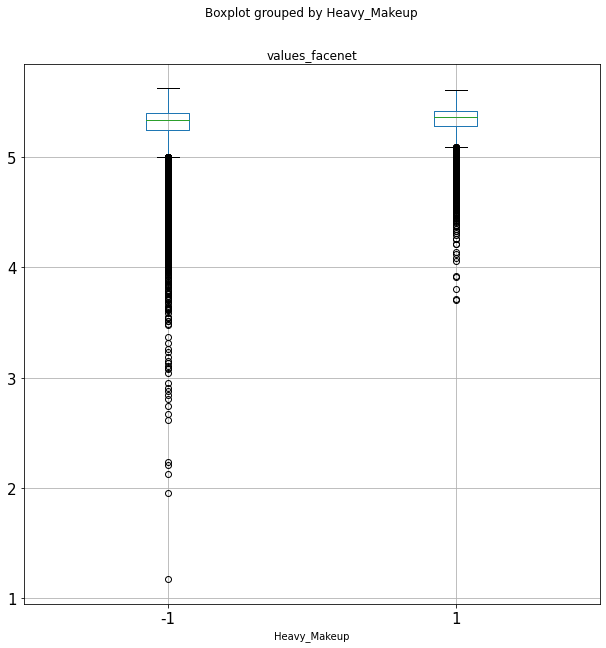

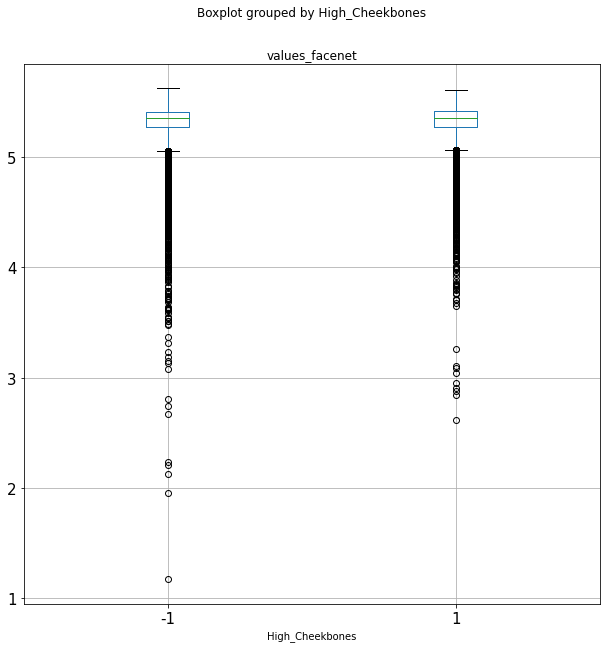

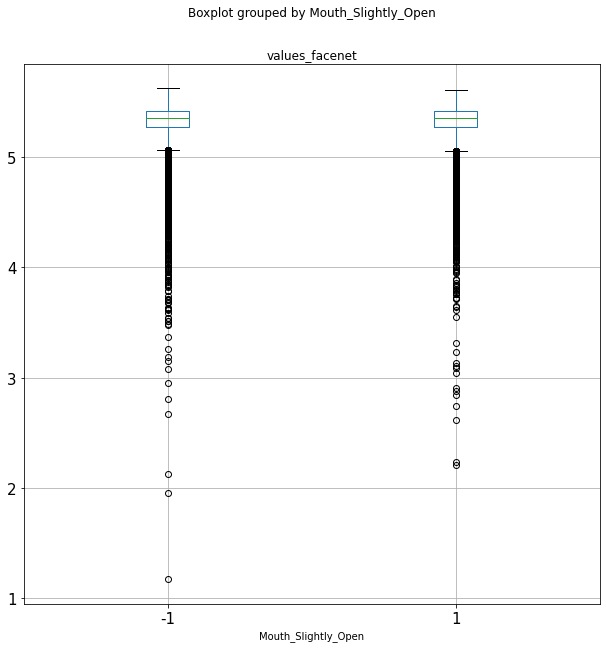

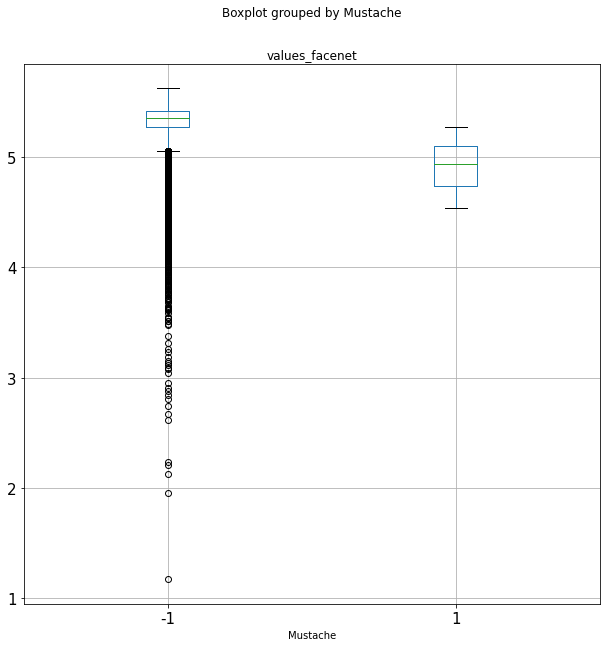

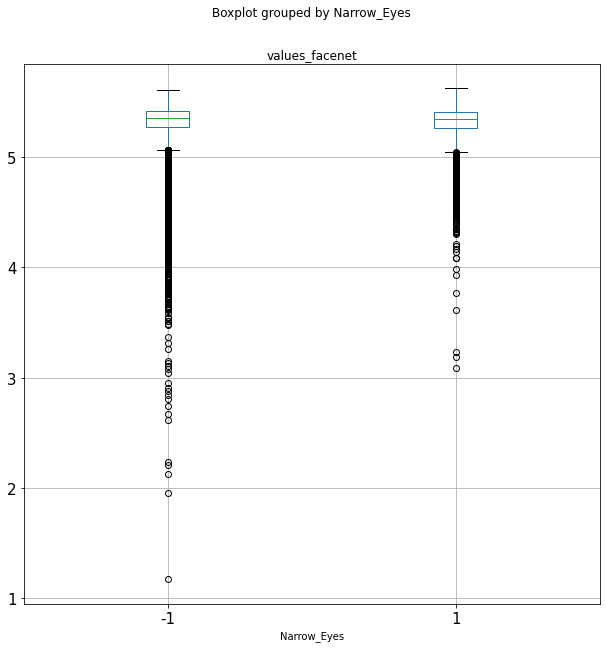

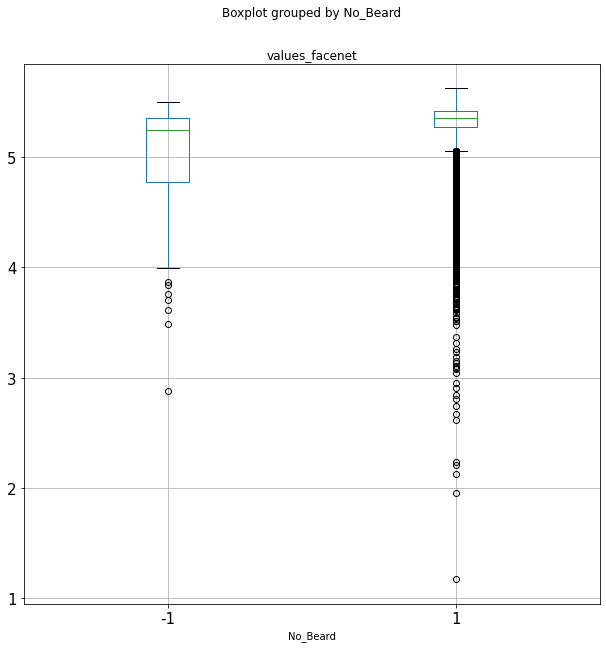

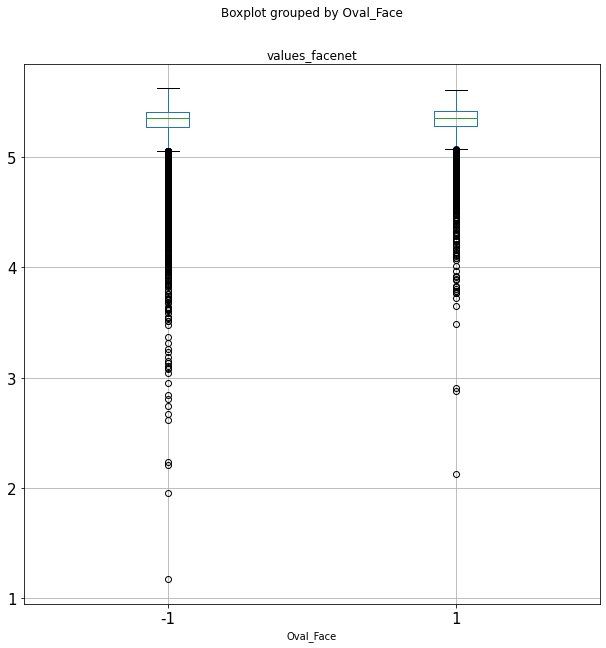

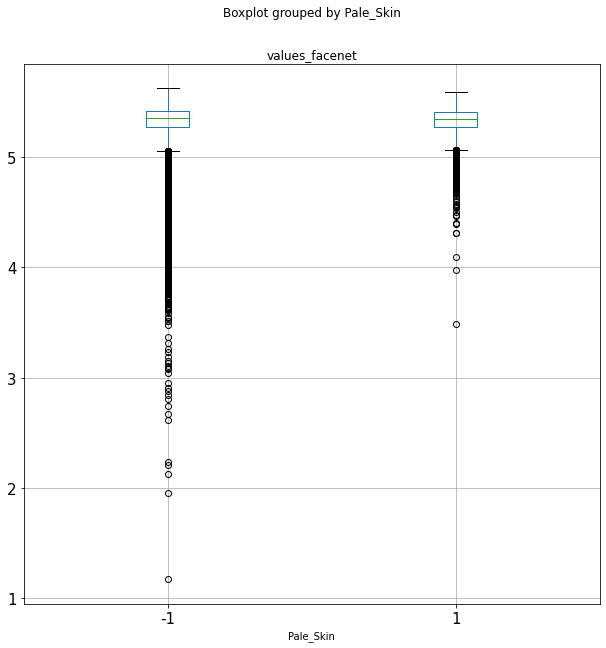

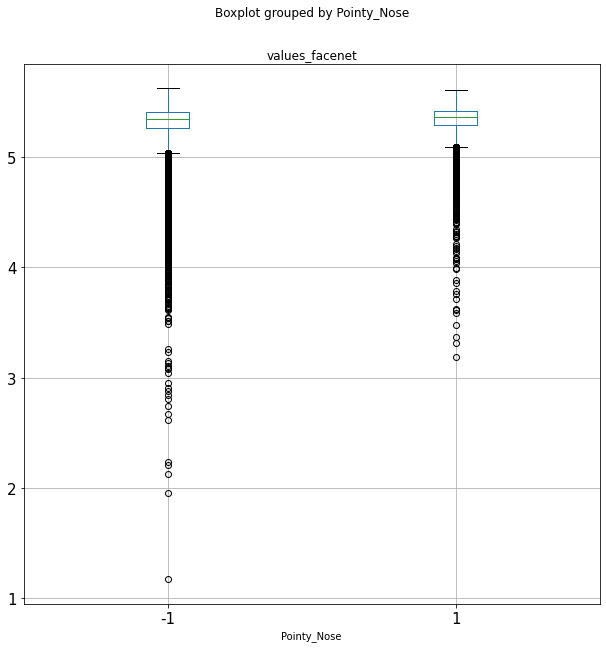

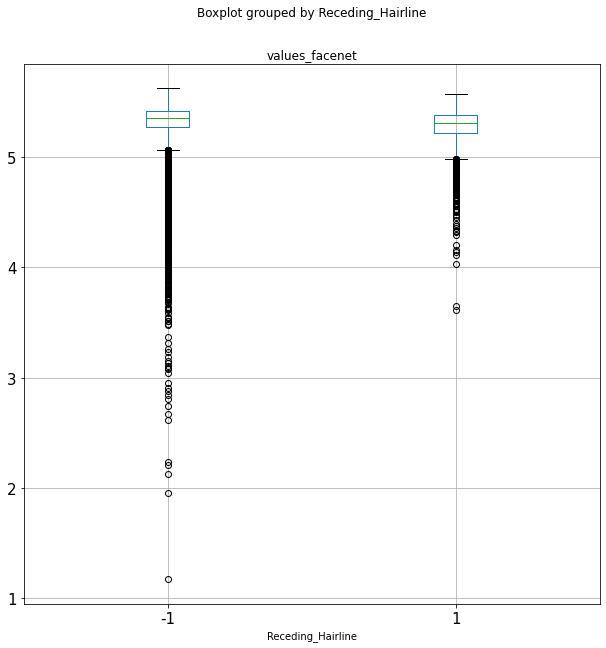

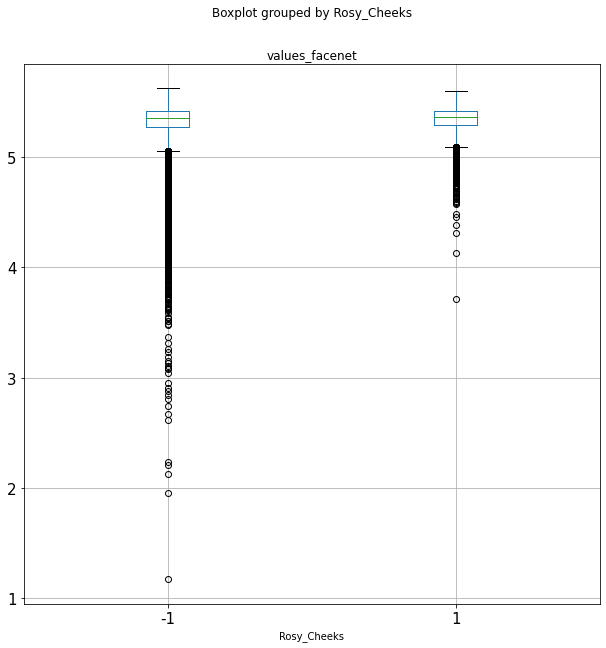

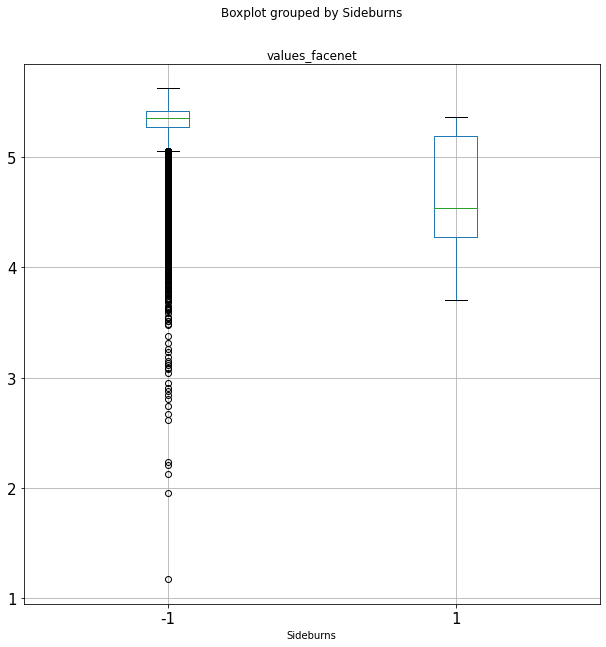

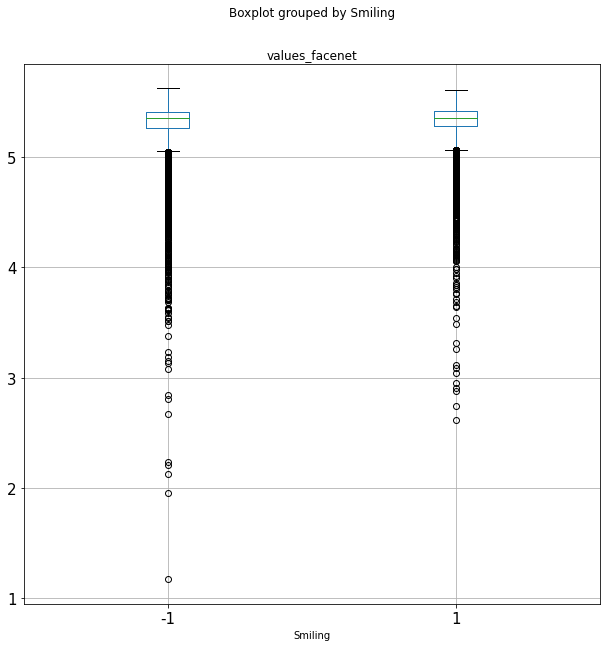

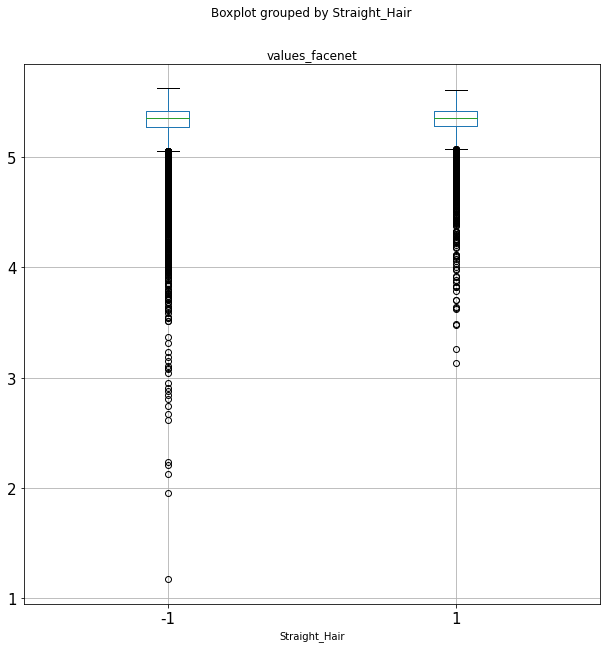

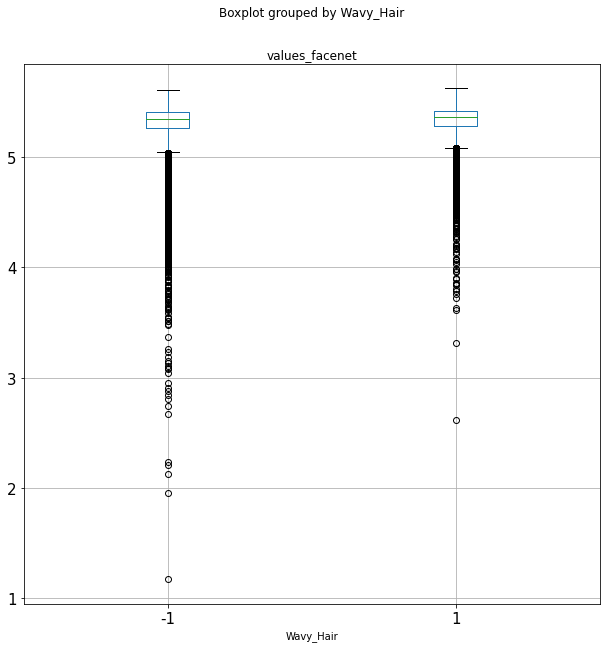

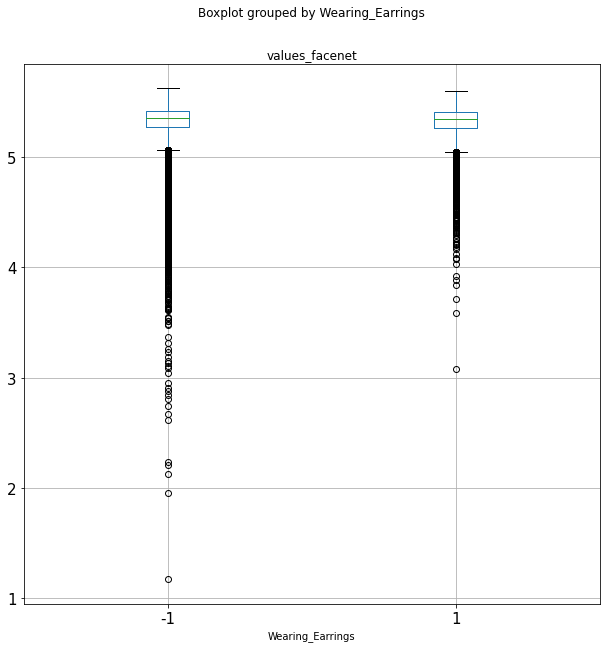

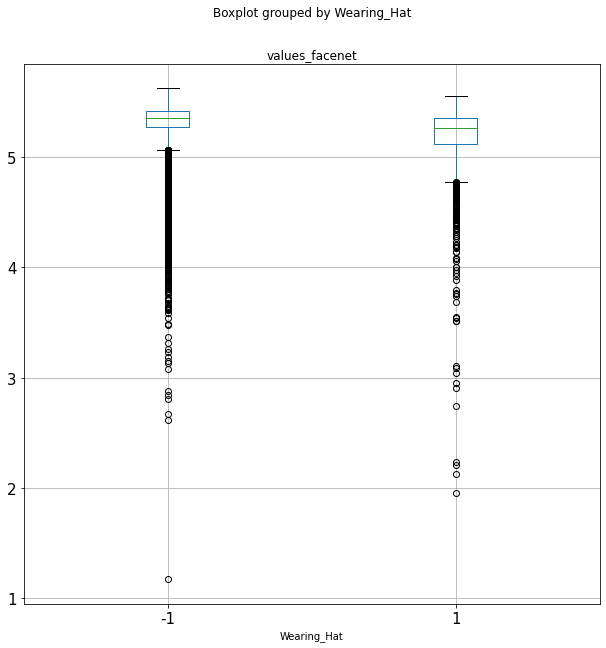

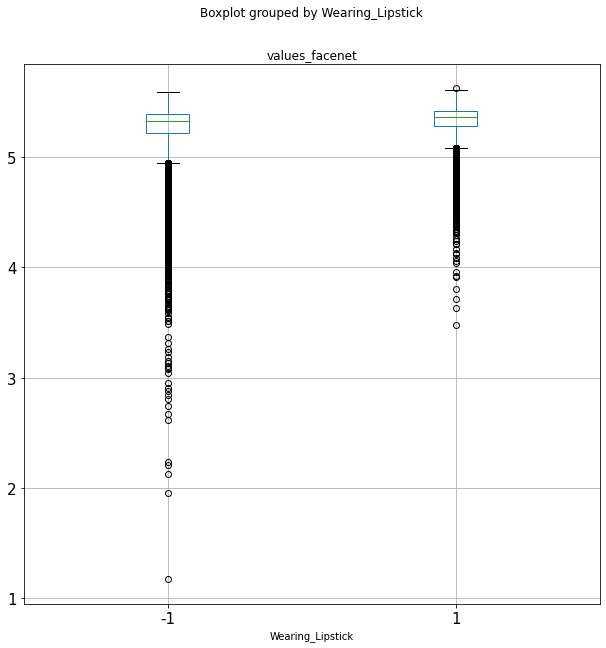

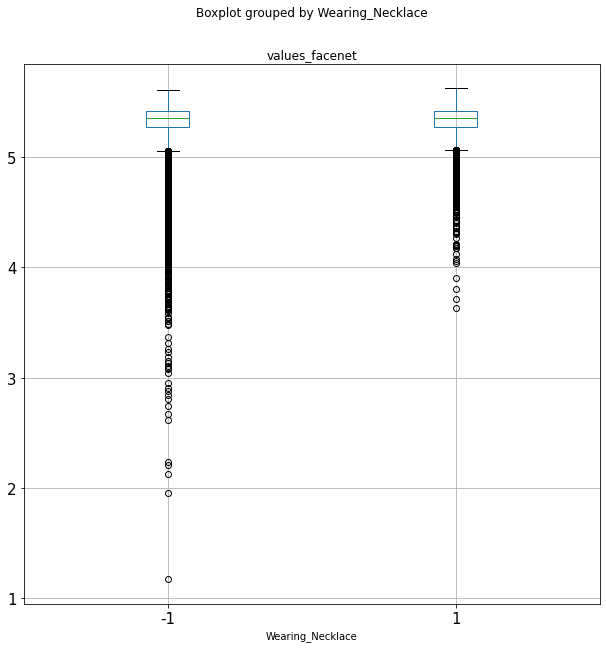

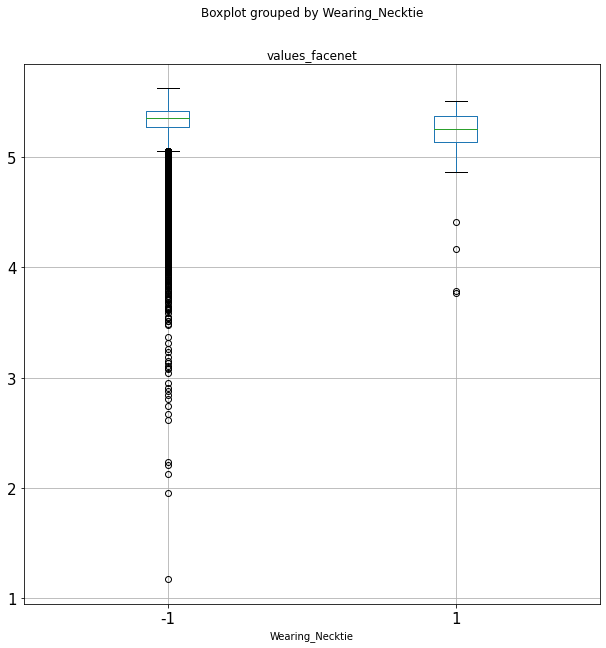

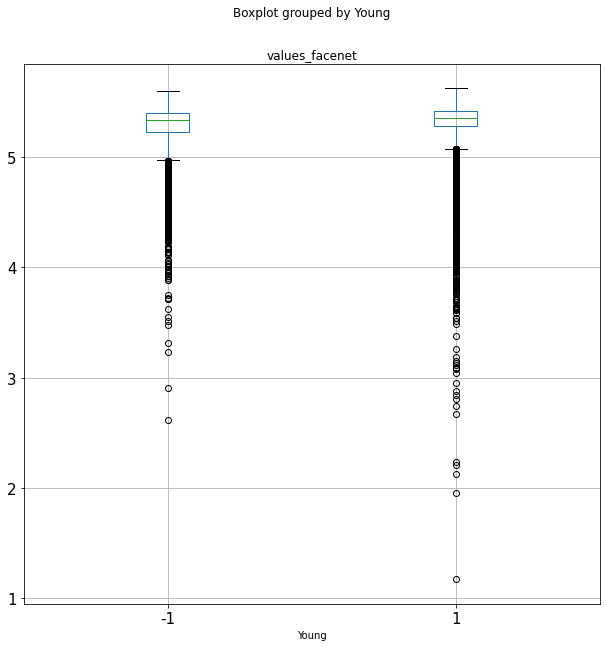

In [14]:
axes = list()
for col in bias.keys():
    axes.append(df_female.boxplot(column="values_facenet",
                  by=col,
                  figsize=(10, 10),
                  fontsize=15)
               )

In [ ]:
def make_histograms(path, df, col, score, gender = "Male"):
    plt.hist(df[df[col] == 1][score])
    plt.title(gender + " " + col)
    plt.savefig(path + "/{}.jpeg".format(col))
    plt.show()

In [ ]:
df_gender = df[df["Male"] == -1]

gender = "Female"
for col in bias.keys():
    make_histograms(results_folder + "/histograms_celeba", df=df_female,
                    col=col, score="values_facenet", gender=gender)
    plt.clf()

In [ ]:
bias.keys()

We plot the top 36 images according to the ranking. 

In [21]:
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [ ]:
img_ids = df_female.sort_values(by="values_facenet", ascending=True)["image_id"][:36]
array_img_vectors = np.array(
    [skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
     for file in img_ids])

In [ ]:
save_images_as_grid("", array_img_vectors)

We open the numpy array of our feature space

In [ ]:
def open_array():
    pass

In [ ]:
path_arr = '../data/facenet'

We plot the TSNE representation of our space. We distinguisce points sampled from the two distributions. The features extracted from female subjects are colered according to our ranking score.

In [ ]:
def plot_tsne(path, array1, array2, scores, label1 = None, label2 = None):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray", label=label1)
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c=scores, cmap="plasma_r", label = label2)
    plt.title("TSNE representation of the feature space")
    
    plt.legend(handles=[sc1, sc2])
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [ ]:
sample = df.sample(5000)

X_data = src.datasets.CelebA_Features(celebA_csv, path_arr)
X_data_sample = torch.utils.data.Subset(X_data, sample.index)

X_loader = torch.utils.data.DataLoader(X_data, batch_size=1)

In [ ]:
sample_space = list()
gender = list()
for batch, _, _, g in X_loader:
    sample_space.append(batch.detach().numpy())
    gender.append(g)
    
sample_space = np.concatenate(sample_space)
gender = np.array(gender)

In [ ]:
sample.reset_index(inplace=True)

sample_female = sample[sample["Male"] == -1].sample(500)
df_score = pd.merge(sample_female, df_female, on = "image_id")
sample_female_score = df_score["values_facenet"].values
sample_female_array = sample_space[sample_female.index]


sample_male = sample[sample["Male"] == 1].sample(500)
sample_male_array = sample_space[sample_male.index]


tsne = TSNE()
transformed_space = tsne.fit_transform(sample_space)

In [ ]:
df_female.values_facenet.mean()

In [ ]:
plot_tsne("",
          transformed_space[sample_male.index],
          transformed_space[sample_female.index],
          sample_female_score, "Men", "Women")

We cluster the features of the top 10% images according to the ranking and show the images that are the closest to the centroids. 

In [ ]:
nintieth_quatile = df[df["Male"] == -1].values_resnet18.quantile(.9)

indices = df[(df["Male"] == -1) & (df["values_resnet18"] >= nintieth_quatile)].index

to_cluster = space[indices]

In [ ]:
kmeans.cluster_centers_

In [ ]:
kmeans = KMeans(n_clusters = 5)

kmeans.fit(to_cluster)

In [ ]:
for i in set(kmeans.labels_):
    # select elements of the cluster
    elements = to_cluster[kmeans.labels_ == i]
    
    centroid = kmeans.cluster_centers_[i]
 
    minimum = elements[np.linalg.norm(elements - centroid, axis = 1).argmin()]

    to_print = np.linalg.norm(space - minimum, axis = 1).argmin()
    
    file = df.loc[to_print, "image_id"]
    image = skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
    
    im = Image.fromarray(image)

    #im.save(path)
    print("Centroid of cluster {}".format(i))
    display(im)
    

In [ ]:
df_female.values_facenet.mean()